# Satellite Image Classification

Training data containing four categories of satellite images is provided. These categories include: 'cloudy', 'desert', 'green_area', and 'water'. A classifier model is built to categorise satellite images into one of these.

In [ ]:
# config
import config

In [74]:
import os
import cv2
import tensorflow
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shutil
import random
from pathlib import Path
import pickle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator,
    img_to_array,
    load_img,
    array_to_img,
)
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
)

In [98]:
# Check device
# returns True if tensorflow is able to successfully access the gpu
print(tf.test.is_built_with_cuda())

# returns an object with /device:GPU:0 as a listed device
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

False
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10930233977513988443
xla_global_id: -1
]


This notebook follows the following steps to build the classifier:
1. Data loading

In [ ]:
# Set TensorFlow's random seed
tf.random.set_seed(config.random_seed)

## Step 1. Data Loading

In [16]:
classes = [
    d
    for d in os.listdir(config.RAW_DATA_DIR)
    if os.path.isdir(os.path.join(config.RAW_DATA_DIR, d))
]


data = []

data_labels = []


for category in classes:

    folder_path = os.path.join(config.RAW_DATA_DIR, category)

    image_paths = os.listdir(folder_path)

    data.extend([os.path.join(folder_path, image_path) for image_path in image_paths])

    data_labels.extend([category] * len(image_paths))

data = pd.DataFrame({"Image_Path": data, "labels": data_labels})
data

,Image_Path,labels
0,C:\Users\ida-c\Git repos\satellite_image_class...,cloudy
1,C:\Users\ida-c\Git repos\satellite_image_class...,cloudy
2,C:\Users\ida-c\Git repos\satellite_image_class...,cloudy
3,C:\Users\ida-c\Git repos\satellite_image_class...,cloudy
4,C:\Users\ida-c\Git repos\satellite_image_class...,cloudy
...,...,...
5626,C:\Users\ida-c\Git repos\satellite_image_class...,water
5627,C:\Users\ida-c\Git repos\satellite_image_class...,water
5628,C:\Users\ida-c\Git repos\satellite_image_class...,water
5629,C:\Users\ida-c\Git repos\satellite_image_class...,water


## 2. Data Visualisation 

Displaying Some Sample images of 'cloudy' category : 
Displaying in BGR


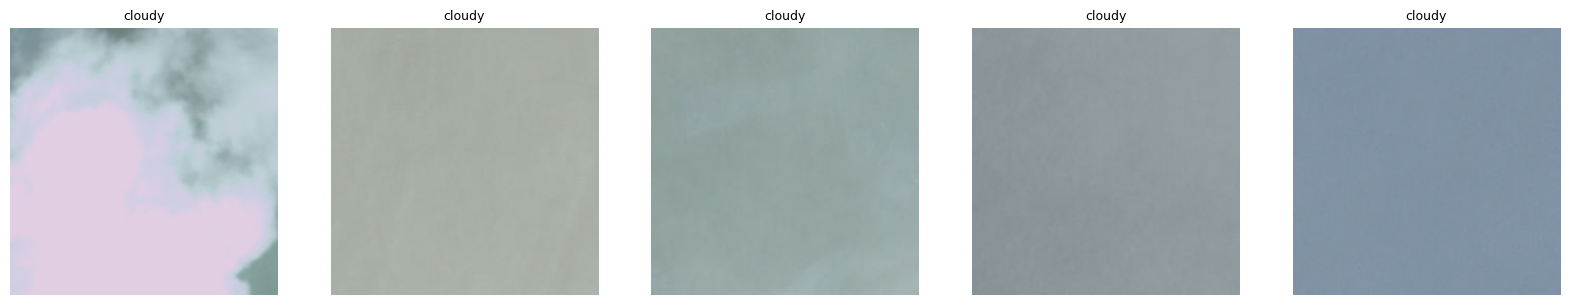

Displaying in RGB


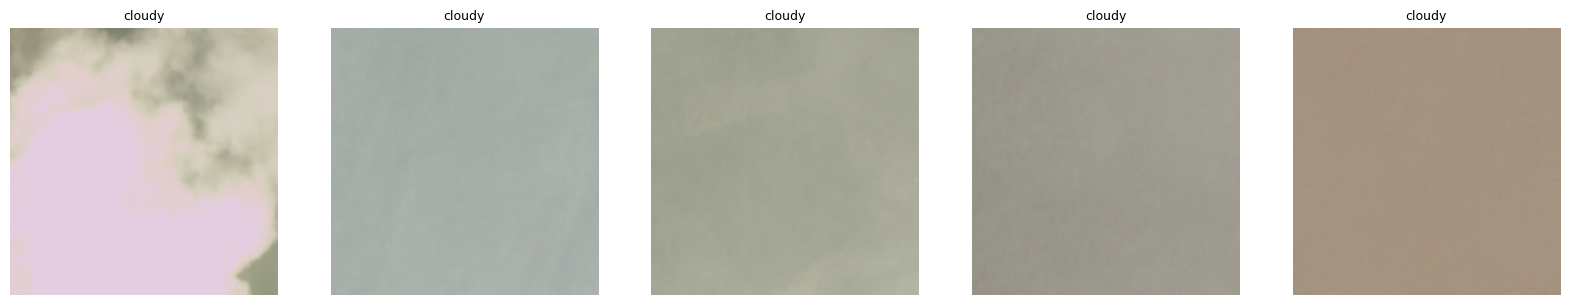

Displaying Some Sample images of 'desert' category : 
Displaying in BGR


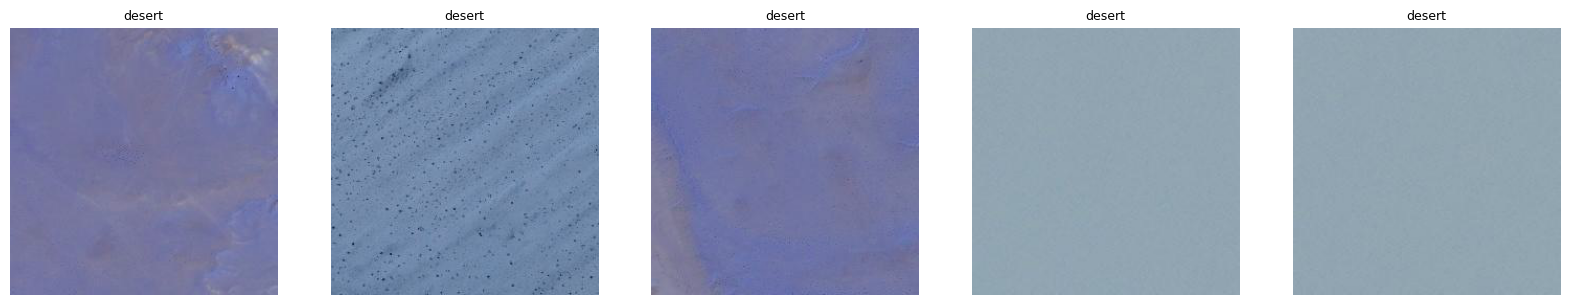

Displaying in RGB


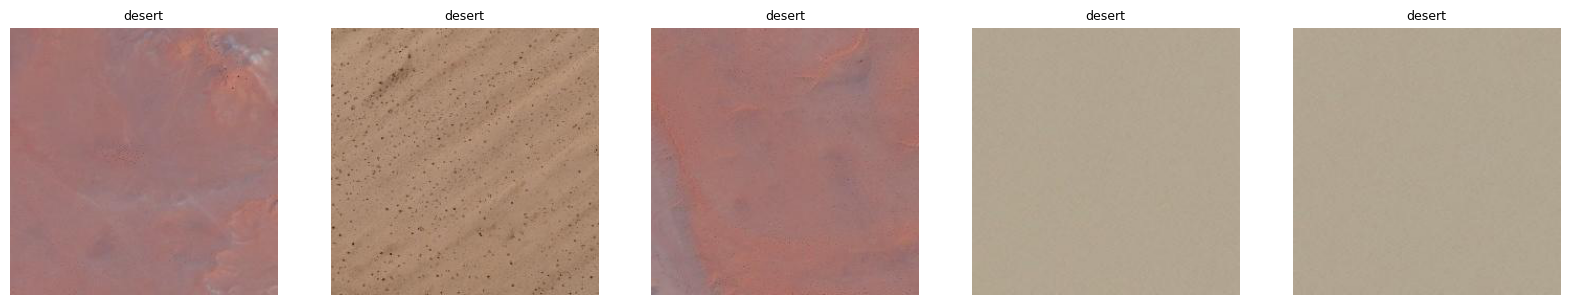

Displaying Some Sample images of 'green_area' category : 
Displaying in BGR


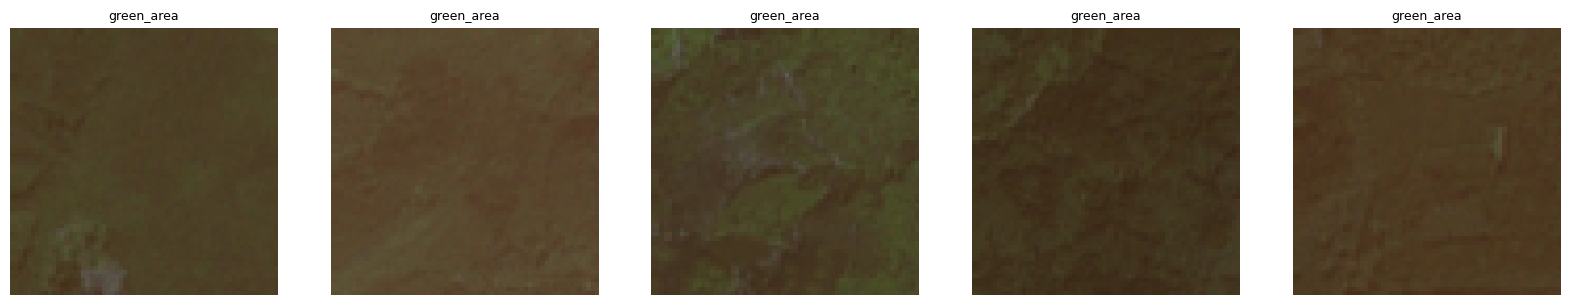

Displaying in RGB


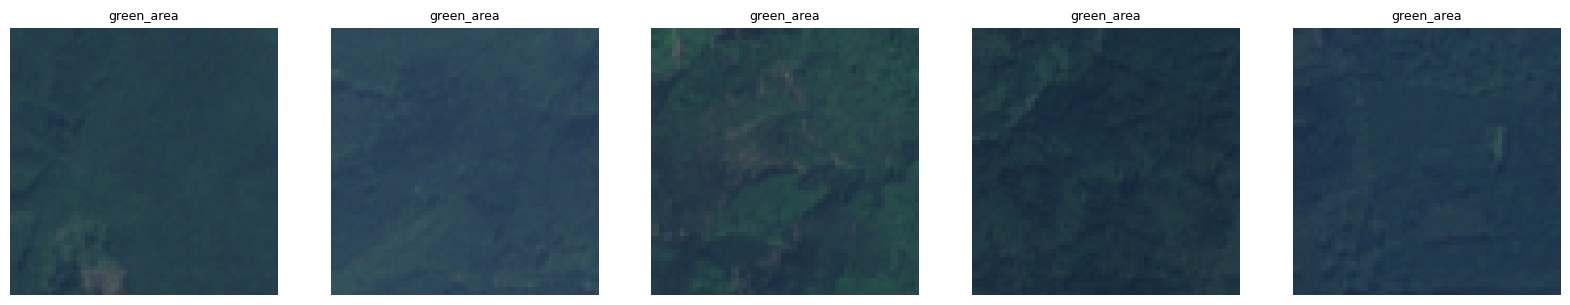

Displaying Some Sample images of 'water' category : 
Displaying in BGR


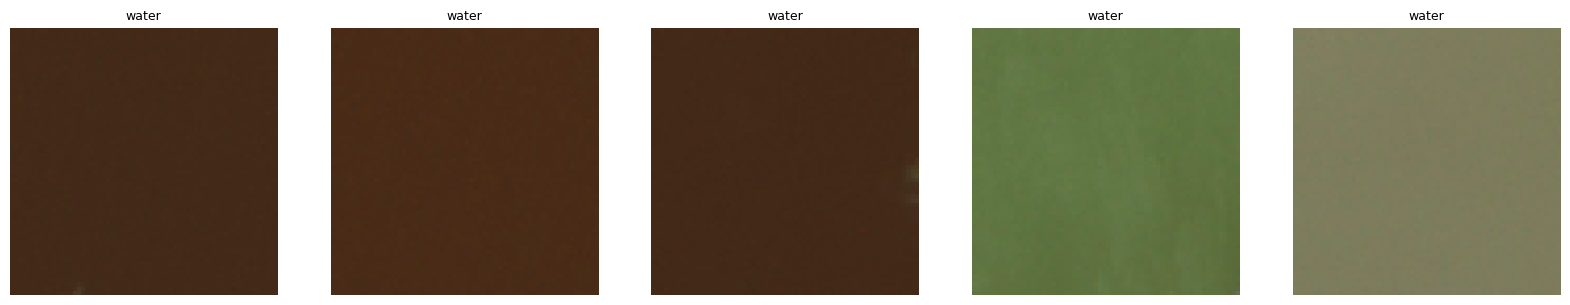

Displaying in RGB


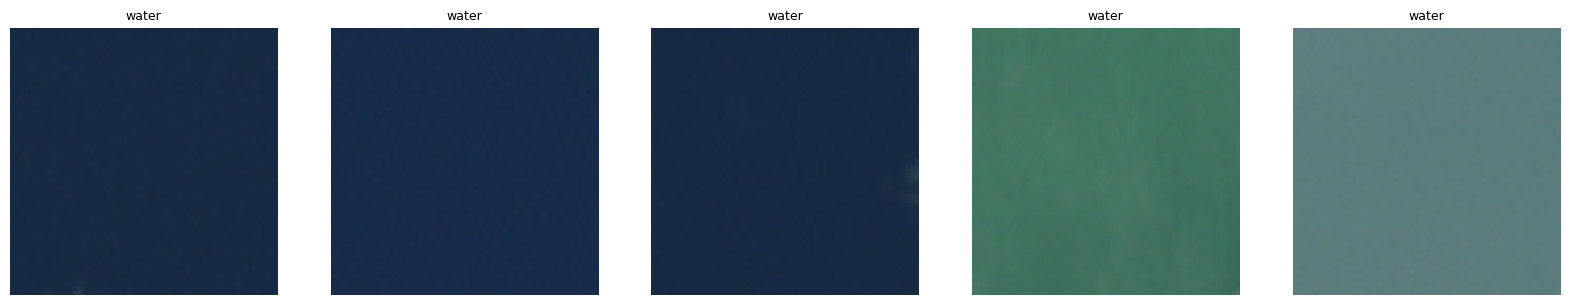

In [91]:
for label in classes:
    sample_images = data[data["labels"] == label]["Image_Path"].reset_index(drop=True)[
        :5
    ]

    print(f"Displaying Some Sample images of '{label}' category : ")
    plt.figure(figsize=(20, 8))
    # Displaying Some Sample images in BGR
    print("Displaying in BGR")
    for i in range(len(sample_images)):
        plt.subplot(2, 5, i + 1)
        img = cv2.imread(sample_images[i])
        plt.imshow(img)
        plt.title(label, fontsize=9)
        plt.axis("off")
    plt.show()
    # Displaying Some Sample images in RGB
    plt.figure(figsize=(20, 8))
    print("Displaying in RGB")
    for i in range(len(sample_images)):
        plt.subplot(2, 5, i + 1 + 5)
        img = cv2.imread(sample_images[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(label, fontsize=9)
        plt.axis("off")

    plt.show()

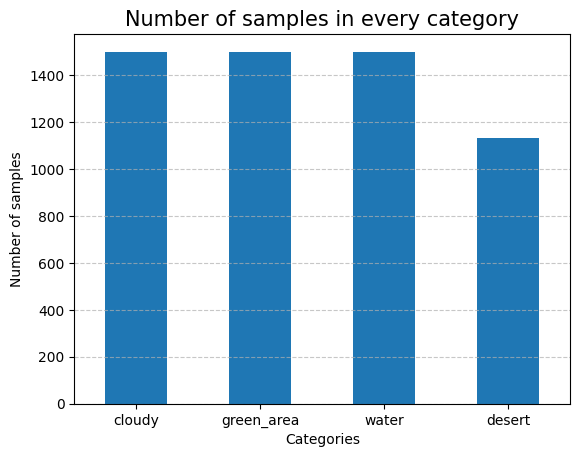

In [98]:
data["labels"].value_counts().plot(kind="bar")
plt.title("Number of samples in every category", fontsize=15)
plt.xlabel("Categories")
plt.ylabel("Number of samples")
plt.xticks(rotation=0)  # Rotate x-axis labels by 90 degrees
plt.grid(axis="y", linestyle="--", alpha=0.7)

## 3. Data Preprocessing and Augmentation

First, we generate more augmented versions of 'desert' images because this class is currently underrepresented, causing class imbalance.

Secondly, we augment across all classes such that all four classes have more training images for the model. We ensure that all classes have the same number of samples by the end of this section.

In [17]:
# Splits raw data into training, test and validation before augmentation

# Configuration
input_dir = config.RAW_DATA_DIR  # original data directory
output_dir = config.INTERIM_DATA_DIR  # destination root directory
split_ratios = (0.7, 0.15, 0.15)  # train, val, test

for cls in classes:
    cls_path = os.path.join(input_dir, cls)
    images = [
        f for f in os.listdir(cls_path) if f.lower().endswith((".jpg", ".jpeg", ".png"))
    ]
    random.shuffle(images)

    n_total = len(images)
    n_train = int(n_total * split_ratios[0])
    n_val = int(n_total * split_ratios[1])

    split_data = {
        "train": images[:n_train],
        "val": images[n_train : n_train + n_val],
        "test": images[n_train + n_val :],
    }

    for split in split_data:
        split_dir = os.path.join(output_dir, split, cls)

        # Clear the folder before recreating it
        if os.path.exists(split_dir):
            for filename in os.listdir(split_dir):
                file_path = os.path.join(split_dir, filename)
                try:
                    if os.path.isfile(file_path) or os.path.islink(file_path):
                        os.unlink(file_path)  # remove file or link
                    elif os.path.isdir(file_path):
                        shutil.rmtree(file_path)  # remove dir
                except Exception as e:
                    print(f"Failed to delete {file_path}. Reason: {e}")

        Path(split_dir).mkdir(parents=True, exist_ok=True)

        for fname in split_data[split]:
            src = os.path.join(cls_path, fname)
            dst = os.path.join(split_dir, fname)
            shutil.copyfile(src, dst)

print("Dataset split into train/val/test folders.")

Dataset split into train/val/test folders.


In [18]:
# Settings for agumenting training data
target_samples_per_class = 3000
height = 128
width = 128
img_size = (height, width)
save_format = "jpg"

# Create augmenter
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # normalised
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="reflect",
)

In [19]:
train_dir = os.path.join(output_dir, "train")

for cls in classes:
    class_dir = os.path.join(train_dir, cls)
    current_images = [
        f
        for f in os.listdir(class_dir)
        if f.lower().endswith((".jpg", ".jpeg", ".png"))
    ]
    current_count = len(current_images)

    print(
        f"{cls}: {current_count} images found. Augmenting to reach {target_samples_per_class}..."
    )

    if current_count >= target_samples_per_class:
        continue  # Skip if we already have enough

    needed = target_samples_per_class - current_count
    augment_count = 0

    while augment_count < needed:
        for img_name in current_images:
            img_path = os.path.join(class_dir, img_name)
            img = load_img(img_path, target_size=img_size)
            x = img_to_array(img)
            x = np.expand_dims(x, axis=0)

            i = 0
            for batch in train_datagen.flow(x, batch_size=1):
                new_img = array_to_img(
                    batch[0] * 255.0
                )  # Undo rescale to save augmented images to disk, as we would want to restore the original pixel scale [0–255] so they can be used later as raw image files
                new_img_name = f"aug_{augment_count}_{img_name}"
                new_img.save(os.path.join(class_dir, new_img_name))
                augment_count += 1
                i += 1
                if augment_count >= needed:
                    break
            if augment_count >= needed:
                break

    print(f"{cls}: Augmented to {target_samples_per_class} images.")

cloudy: 1050 images found. Augmenting to reach 3000...
cloudy: Augmented to 3000 images.
desert: 791 images found. Augmenting to reach 3000...
desert: Augmented to 3000 images.
green_area: 1050 images found. Augmenting to reach 3000...
green_area: Augmented to 3000 images.
water: 1050 images found. Augmenting to reach 3000...
water: Augmented to 3000 images.


In [ ]:
# Generate rescaled validation and test set (without augmentation)
val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_data = train_datagen.flow_from_directory(
    config.INTERIM_DATA_DIR + "/train",
    target_size=img_size,
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
)

test_data = val_test_datagen.flow_from_directory(
    config.INTERIM_DATA_DIR + "/test",
    target_size=img_size,
    class_mode="categorical",
    shuffle=False,
)

val_data = val_test_datagen.flow_from_directory(
    config.INTERIM_DATA_DIR + "/val",
    target_size=img_size,
    class_mode="categorical",
    shuffle=False,
)

Found 12000 images belonging to 4 classes.
Found 846 images belonging to 4 classes.
Found 844 images belonging to 4 classes.


## 4. Building the CNN model

In [106]:
# Build an improved CNN model
model = Sequential(
    [
        layers.Input(shape=(height, width, 3)),
        # First convolutional block
        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        # Second convolutional block
        layers.Conv2D(64, 3, padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(64, 3, padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.3),
        # Third convolutional block
        layers.Conv2D(128, 3, padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.4),
        # Fully connected layers
        layers.Flatten(),
        layers.Dense(256, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(len(classes)),
    ]
)

In [107]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [108]:
# Create callbacks for training
early_stopping = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=3, min_lr=0.00001
)

## 5. Training the CNN model

In [ ]:
# Train model with callbacks

if config.train_model:

    epochs = 20  # Set higher epochs since we have early stopping
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,

        callbacks=[early_stopping, reduce_lr],
    )

    # Save history after training
    with open(config.MODELS_DIR + "/" + config.model_history_filename, "wb") as f:
        pickle.dump(history.history, f)

    # Save model after training
    model.save(config.MODELS_DIR + "/" + config.trained_model_filename)
    print("Model saved successfully")


else: # if the model has been trained, just load the saved history and model config

    # Load history
    with open(config.MODELS_DIR + "/" + config.model_history_filename, "rb") as f:
        history = pickle.load(f)

    model = keras.models.load_model(
        config.MODELS_DIR + "/" + config.trained_model_filename
    )

c:\Users\ida-c\anaconda3\envs\satellite_classifier\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 28 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [11]:
# Model summary
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,062,090 (65.09 MB)

 Trainable params: 8,530,468 (32.54 MB)

 Non-trainable params: 1,152 (4.50 KB)

 Optimizer params: 8,530,470 (32.54 MB)

## 6. Evaluate the model

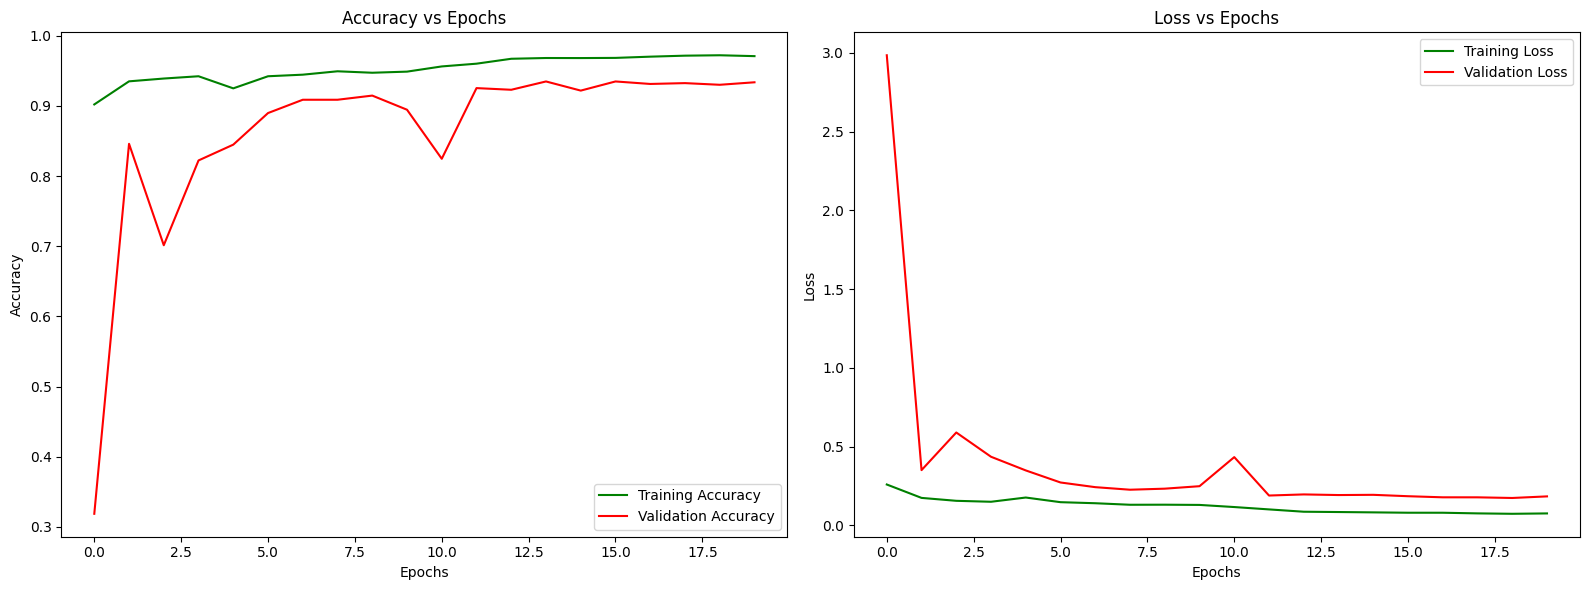

In [111]:
# Plot training performance
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs_range = range(len(accuracy))

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label="Training Accuracy", color="green")
plt.plot(epochs_range, val_accuracy, label="Validation Accuracy", color="red")
plt.legend(loc="lower right")
plt.title("Accuracy vs Epochs")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss", color="green")
plt.plot(epochs_range, val_loss, label="Validation Loss", color="red")
plt.legend(loc="upper right")
plt.title("Loss vs Epochs")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.tight_layout()
plt.show()

In [37]:
# Evaluate on validation set
val_loss, val_accuracy = model.evaluate(val_data, verbose=0)
print(f"Validation accuracy: {val_accuracy:.4f}")
print(f"Validation loss: {val_loss:.4f}")

# Evaluate on training set
train_loss, train_accuracy = model.evaluate(train_data, verbose=0)
print(f"Train accuracy: {train_accuracy:.4f}")
print(f"Train loss: {train_loss:.4f}")

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_data, verbose=0)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

Validation accuracy: 0.9360
Validation loss: 0.1711
Train accuracy: 0.9792
Train loss: 0.0561


c:\Users\ida-c\anaconda3\envs\satellite_classifier\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Test accuracy: 0.9243
Test loss: 0.1842


27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step

Classification Report:
              precision    recall  f1-score   support

      cloudy     0.9641    0.9556    0.9598       225
      desert     0.9641    0.9527    0.9583       169
  green_area     0.9193    0.9111    0.9152       225
       water     0.9048    0.9289    0.9167       225

    accuracy                         0.9360       844
   macro avg     0.9381    0.9371    0.9375       844
weighted avg     0.9363    0.9360    0.9361       844


Confusion Matrix:
[[215   6   2   2]
 [  8 161   0   0]
 [  0   0 205  20]
 [  0   0  16 209]]


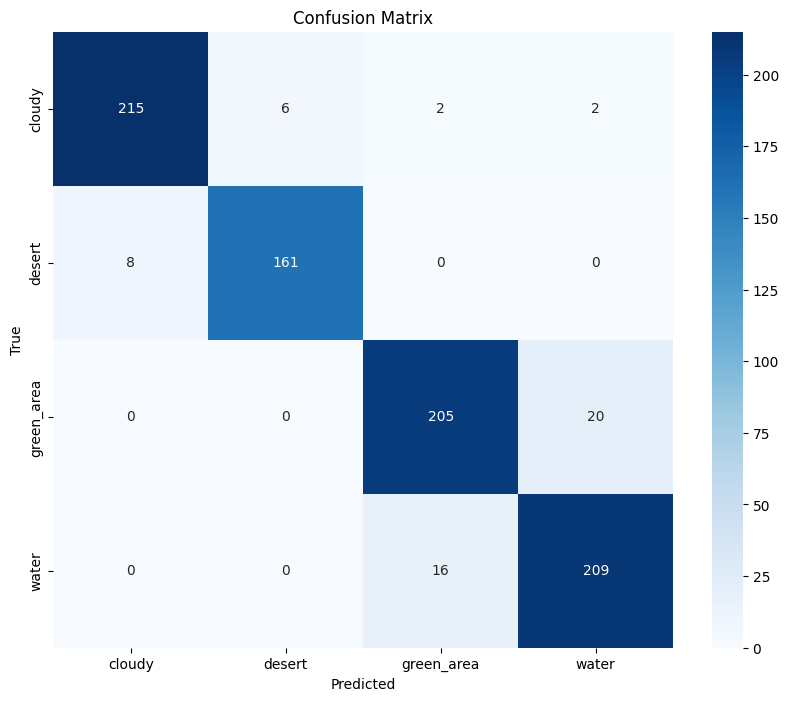

Accuracy for class cloudy: 0.9556
Accuracy for class desert: 0.9527
Accuracy for class green_area: 0.9111
Accuracy for class water: 0.9289


In [ ]:
# Predict the whole test set
y_pred_probs = model.predict(test_data, verbose=1)  # verbose shows a progress bar
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels directly from the generator
y_true = test_data.classes  # <<< no need for np.argmax!

# Class names
class_names = list(test_data.class_indices.keys())

# Now proceed to evaluation
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Save to CSV or Excel for easy copy-paste into Word
report_dict = classification_report(
    y_true, y_pred, target_names=class_names, digits=4, output_dict=True
)
report_df = pd.DataFrame(report_dict).transpose()
for col in ["precision", "recall", "f1-score"]:
    if col in report_df.columns:
        report_df[col] = report_df[col].astype(float)
report_df.to_csv(
    config.OUTPUT_DIR + "/classification_report.csv", float_format="%.4f"
)  # saves as CSV

conf_mat = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_mat)

plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Accuracy per class
class_accuracy = conf_mat.diagonal() / conf_mat.sum(axis=1)
for idx, acc in enumerate(class_accuracy):
    print(f"Accuracy for class {class_names[idx]}: {acc:.4f}")

## 7. Final Predictions

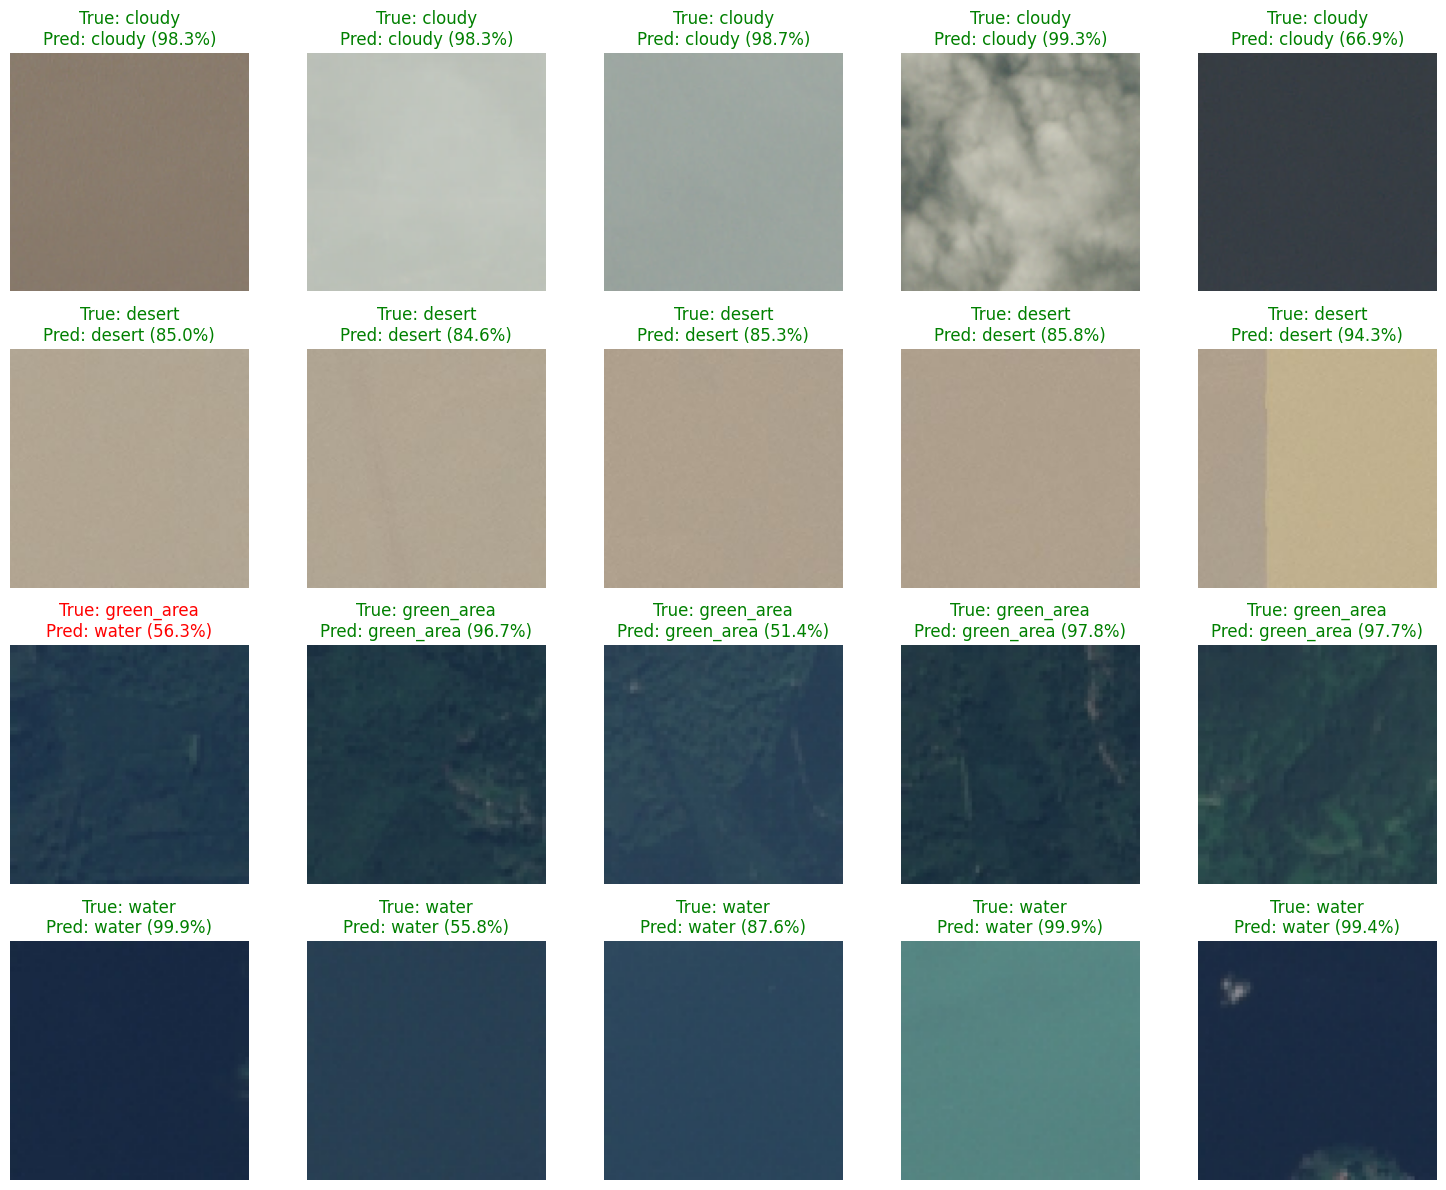

In [ ]:
def visualise_predictions_by_class(dataset, model, class_names, num_images_per_class=5):
    plt.figure(figsize=(15, 12))

    # Get class indices from dataset
    class_indices = dataset.class_indices
    reverse_class_indices = {
        v: k for k, v in class_indices.items()
    }  # Map from index to class name

    # Initialize dictionaries to store images per class
    class_images = {class_name: [] for class_name in class_names}
    class_labels = {class_name: [] for class_name in class_names}

    # Gather images for each class
    for i, (images, labels) in enumerate(dataset):
        for j in range(len(images)):
            true_label_index = tf.argmax(
                labels[j]
            ).numpy()  # Get the index of the true class

            # Check if the image belongs to one of the specified classes
            true_class_name = reverse_class_indices[true_label_index]
            if (
                true_class_name in class_names
                and len(class_images[true_class_name]) < num_images_per_class
            ):
                class_images[true_class_name].append(images[j])
                class_labels[true_class_name].append(true_label_index)

            # Stop once we have collected enough images for each class
            if all(
                len(class_images[class_name]) >= num_images_per_class
                for class_name in class_names
            ):
                break
        if all(
            len(class_images[class_name]) >= num_images_per_class
            for class_name in class_names
        ):
            break

    # Plot images for each class
    for idx, class_name in enumerate(class_names):
        for i in range(num_images_per_class):
            sample_image = class_images[class_name][i]
            true_label = class_labels[class_name][i]

            # Rescale image to 0-255 for correct visualization
            sample_image_rescaled = sample_image * 255.0  # Convert to 0-255 range

            # Get prediction
            sample_image_expanded = tf.expand_dims(sample_image, axis=0)
            predictions = model.predict(sample_image_expanded, verbose=0)
            predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]

            # Calculate confidence
            softmax_preds = tf.nn.softmax(predictions).numpy()[0]
            confidence = softmax_preds[predicted_class_index] * 100

            # Plot
            plt.subplot(
                len(class_names),
                num_images_per_class,
                idx * num_images_per_class + i + 1,
            )
            plt.imshow(sample_image_rescaled.astype("uint8"))  # Display rescaled image
            color = "green" if predicted_class_index == true_label else "red"
            plt.title(
                f"True: {class_name}\nPred: {reverse_class_indices[predicted_class_index]} ({confidence:.1f}%)",
                color=color,
            )
            plt.axis("off")

    plt.tight_layout()
    plt.show()


# Visualize 5 sample images from each of the 4 specified classes
visualise_predictions_by_class(test_data, model, class_names)